# BGPDistinct: Data Experimentation
*Quick notes and graphics on the BGP data and some of its characteristics*

*Author: Andy Dolan*

In [1]:
import json
import matplotlib.pyplot as plt
import sys
from datetime import datetime as dt
import math
import statistics
%matplotlib inline

## Some Example Data
The following lines import some preprocessed data from an original set of over 250,000 BGP messages from a single collector during a single hour on November 1st, 2018. The preprocessing step was responsible for properly formatting the JSON data and filtering out any unwanted or malformed BGP messages.

In [2]:
# Your file here
filename = '../data/formatted_large_set.json'
with open(filename) as f:
    all_announcements = json.load(f)

In [3]:
print('Total number of announcements in dataset: {:d}'.format(len(all_announcements)))
print(json.dumps(all_announcements[0].get('bgp_update'), indent=2))

Total number of announcements in dataset: 254911
{
  "advertized_routes": [
    {
      "prefix": "45.123.119.0",
      "mask": 24
    }
  ],
  "attrs": {
    "optional_bit": true,
    "as_path": [
      {
        "as_seq": [
          852,
          174,
          2914,
          9121,
          9121,
          43260,
          134094
        ]
      }
    ],
    "types": [
      1,
      2,
      3,
      4
    ],
    "next_hop": "154.11.12.212"
  }
}


## Extracting Characteristics; Inflating Data
The FIRST thing that we should do is limit the data in each message to the key characteristics that we most care about.

For the purposes of this project, we will utilize four important characteristics of any BGP announcement:
1. The timestamp of the announcement.
2. The prefix being announced.
3. The mask of the prefix being announced.
4. The final destination/owner of the prefix being announced.

Of these characteristics, the latter three are most important, since a message may belong to the same event as another message if they share the same prefix, mask, and destination AS. However, this is not a guarantee, since their temporal difference may indicate otherwise.

One troubling item is that the BGP4 specification allows for multiple prefixes to be announced in a single message, assuming that they are all related to the final destination AS. If we want to consider different prefixes as distinct announcements, we must treat these kinds of messages as separate by each prefix.

For example, consider a BGP4 message that announces three prefixes, all attributed to the same final destination AS. We will consider this announcement as three separate BGP announcements, all captured at the same timestamp (that of the original message), each with a unique prefix, and each having the same final destination AS.

To alter the original data in this way, we must separate all messages with *n* prefixes advertised into _n_ separate messages, each with a single prefix. We now define a function to do so, as well as extract the key characteristics listed above:

In [4]:
def transform_data(data):
    """Extract the key characteristics of the provided BGP data and 'inflate' messages
    that contain multiple advertised prefixes. That is, create a separate message for each
    advertised prefix.
    Args:
    data (list of dict): The original input structure of formatted BGP messages.
    Returns:
    A new list of tuples that each contain key characteristics of announcements: a timestamp,
        (a single) prefix+mask, and a final destination AS.
    """
    transformed_data = []
    for message in data:
        tstamp = message.get('mrt_header').get('timestamp')
        dest = message.get('bgp_update').get('attrs').get('as_path')[-1].get('as_seq')[-1]
        transformed_data.extend([(tstamp, r.get('prefix'), r.get('mask'), dest) for r in message.get('bgp_update').get('advertized_routes')])
    return transformed_data

In [5]:
# The data that will be used for the remainder of this notebook
transformed_data = transform_data(all_announcements)
print('Original number of BGP messages: {:d}'.format(len(all_announcements)))
print('Number of BGP messages with single prefix, mask, and destination: {:d}'.format(len(transformed_data)))

Original number of BGP messages: 254911
Number of BGP messages with single prefix, mask, and destination: 692127


This transformation clearly demonstrates that there are many BGP messages that contain multiple prefixes, which is probably a good thing. From here on, keep in mind that any one "message" is now a tuple that looks like the following:

In [6]:
transformed_data[0]

(1541030400.0, '45.123.119.0', 24, 134094)

## Playing with the Data
Let's start by investigating some of the `AS_PATH` attributes of these messages. Note that this data has had any messages that include an `AS_SET` (unordered) instead of an `AS_SEQ` (ordered) filtered out. Here's an example of a fragment of an `AS_PATH`:

In [7]:
all_announcements[0].get('bgp_update').get('attrs').get('as_path')

[{'as_seq': [852, 174, 2914, 9121, 9121, 43260, 134094]}]

From our transformed data, let's determine how many unique AS destinations there were.

In [8]:
print('Number of messages: {:d}'.format(len(transformed_data)))
all_dests = [m[-1] for m in transformed_data]
unique_dests = set(all_dests)
print('Number of unique final AS destinations: {:d}'.format(len(unique_dests)))

Number of messages: 692127
Number of unique final AS destinations: 5293


There are clearly several messages that share the same final destination. This does not necessarily mean that there are only distinct events for each final destination, however, as different messages may pertain to a different prefix owned by the same final AS. Additionally, the temporal difference may also indicate that different messages that lead to the same AS for the same prefix are distinct as well.

Let's also see what the most popular AS destinations were:

In [9]:
as_counts = sorted([(d, all_dests.count(d)) for d in unique_dests], key=lambda x: x[1], reverse=True)
as_counts[:10]

[(747, 47827),
 (15169, 38922),
 (37492, 37399),
 (132165, 37283),
 (25435, 18122),
 (268447, 10575),
 (9829, 8260),
 (8901, 8186),
 (48095, 7556),
 (48434, 6288)]

Let's plot these metrics:

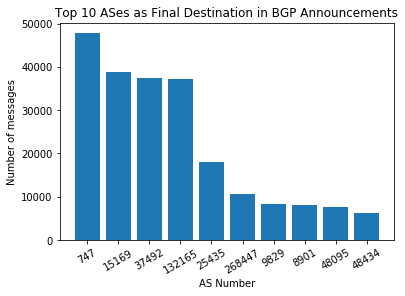

In [10]:
fig, ax = plt.subplots()

chart = ax.bar([str(a[0]) for a in as_counts[:10]], [a[1] for a in as_counts[:10]])
plt.xticks(rotation=30)
ax.set_xlabel('AS Number')
ax.set_ylabel('Number of messages')
ax.set_title('Top 10 ASes as Final Destination in BGP Announcements')

plt.show()

We can use the `whois` command to see what routes are attributed to a particular AS. Let's take a look at that for the most popular selection...

In [11]:
# Only run the following if we have whois/grep built-in...
if sys.platform in ['linux', 'darwin']:
    !whois -h whois.radb.net -- -i origin AS{as_counts[0][0]} | grep 'descr:\|route:'
else:
    print('Running Windows, skipping...')

route:      204.208.28.0/24
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.208.31.0/24
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.208.32.0/21
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.208.40.0/22
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      143.77.0.0/16
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      143.138.0.0/16
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      144.59.0.0/16
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      147.242.0.0/16
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      160.135.0.0/16
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.37.129.0/24
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.208.29.0/24
descr:      Proxy-Registered Route Object by DACOM(AS3786)
route:      204.208.30.0/24
descr:      Proxy-Regi

This seems to be an AS that holds ownership over quite a few prefixes, hence a larger number of our distinct messages.

### Bringing Prefixes into the Mix
We have determined that the number of unique final-destination AS numbers is significantly less than the total number of messages broadcast/propagated for any time period. How does the number of unique prefixes compare?

In [12]:
unique_prefixes = set([m[1] for m in transformed_data])
print('Number of unique prefixes from all announcements: {:d}'.format(len(unique_prefixes)))

Number of unique prefixes from all announcements: 30045


What if we also bring the prefix mask into account?

In [13]:
unique_pf_masks = set([(m[1], m[2]) for m in transformed_data])
print('Number of unique prefixes and masks from all announcements: {:d}'.format(len(unique_pf_masks)))

Number of unique prefixes and masks from all announcements: 31357


Very intersting... This appears to make only a small difference, on the order of 5% or less. Still, prefixes of different mask lengths should be considered unique, as they are in routing.

So then, what is the total number of unique (prefix, mask, destination) tuples for the set?

In [14]:
all_extracted_messages = [(p, m, d) for _, p, m, d in transformed_data]
unique_messages = set(all_extracted_messages)
print('Total number of unique (prefix, mask, destination) combinations: {:d}'.format(len(unique_messages)))

Total number of unique (prefix, mask, destination) combinations: 31428


This is especially interesting, as it reveals that different destination ASes announce the same prefix...

We now have some idea of how the number of these "distinctly" identified messages compares to the full number of messages.

## Experimenting with the Temporal Side of Data
Let's now investigate how putting different messages into different time-interval "buckets" results in different numbers of these unique (prefix, mask, AS number) tuples. Note that the timestamps on each BGP message are marked only down to the second.

First off, how many unique timestamps are there, what's their range?

In [15]:
times = [single[0] for single in transformed_data]

In [16]:
times.sort()
unique_times = set(times)
print('There are {:d} unique timestamps'.format(len(unique_times)))
print('First time:')
print(dt.utcfromtimestamp(times[0]))
print('Last time:')
print(dt.utcfromtimestamp(times[-1]))

There are 2149 unique timestamps
First time:
2018-11-01 00:00:00
Last time:
2018-11-01 01:00:00


### Breaking into Buckets
Let's now divide up the announcements into different "buckets" of time, where each bucket is of the same time interval in seconds.

In [17]:
def create_buckets(messages, interval):
    """Create a number of time period 'buckets' during each of which BGP messages occurred.
    Args:
    interval (int): The interval at which to split buckets, in seconds.
    messages (list of tuple): The 'messages' to organize.
    Returns:
    A dict with the appropriate number of buckets and all messages inside each bucket.
    """
    # First retrieve times and sort them
    times = sorted([single[0] for single in messages])
    
    # Assemble buckets
    start_time = times[0]
    end_time = times[-1]
    num_buckets = round((end_time - start_time) / interval)

    # Divide up the announcements into their proper buckets
    time_divided = {b: [] for b in range(num_buckets)}

    for m in messages:
        tstamp = m[0]
        bucket = min(math.floor((tstamp - start_time) / interval), num_buckets - 1)
        time_divided[bucket].append((m[1], m[2], m[3]))
    return time_divided

We also define a function to plot the number of unique messages in each time interval:

In [18]:
def plot_buckets(time_buckets, interval):
    """Plot the number of messages captured during each specified time interval.
    Args:
    time_buckets (dict): The dictionary of 'time buckets' that contains each set of
        detected messages during each bucket.
    interval (int): The actual interval of the time buckets.
    """
    bucket_lens = [len(b) for b in time_buckets.values()]
    buckets = ['{:d}-{:d}'.format((b * interval), ((b + 1) * interval)) for b in time_buckets.keys()]
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    bars = ax.bar(buckets, bucket_lens)
    # Remove x ticks if there are many data points
    if len(buckets) > 40:
        plt.tick_params(labelbottom=False)
    plt.xticks(rotation=90)
    plt.title('BGP messages divided into time buckets')
    plt.ylabel('No. of messages')
    plt.xlabel('Time bucket (intervals of seconds)')
    plt.show()

Let's start with a 20 second interval and see what the general spread looks like.

In [19]:
interval = 20
td = create_buckets(transformed_data, interval)

The plot below demonstrates the distribution of messages receieved during 20 second intervals. There are clearly some set periods of downtime, as well as some interesting spikes in the number of raw messages.

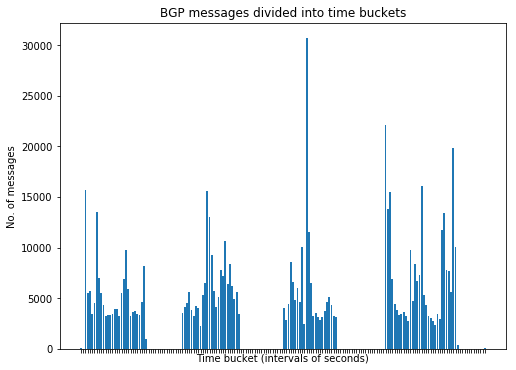

In [20]:
plot_buckets(td, interval)

Let's adjust the interval to be a bit less granular. The plot below divides the messages captured into buckets of 60 second durations. There are still clear intervals during which no messages were received (at least for this dataset/collector).

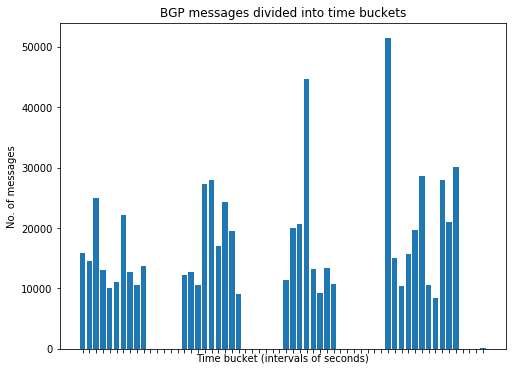

In [21]:
interval = 60
td = create_buckets(transformed_data, interval)
plot_buckets(td, interval)

### Revisiting "Unique" Destinations
What about if we change the number of total messages to the number of messages with a unique prefix/mask and final destination?

In [22]:
# Convert the current buckets to contain only the unique destinations seen during
# that time period
buckets_unique = {k: set(v) for (k, v) in td.items()}

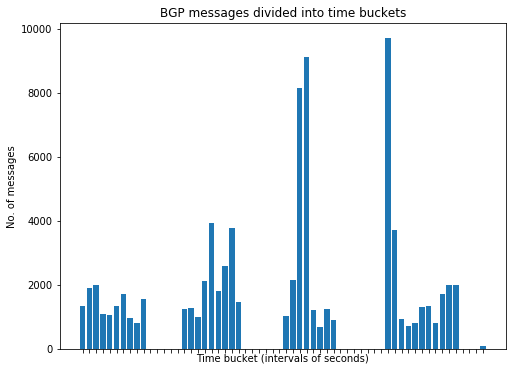

In [23]:
# Now plot this new information; function is still applicable
plot_buckets(buckets_unique, interval)

To make the difference between the number of raw messages per each time period and the number of "unique" messages (in terms of prefix, mask, and destination AS) clear, let's plot them together:

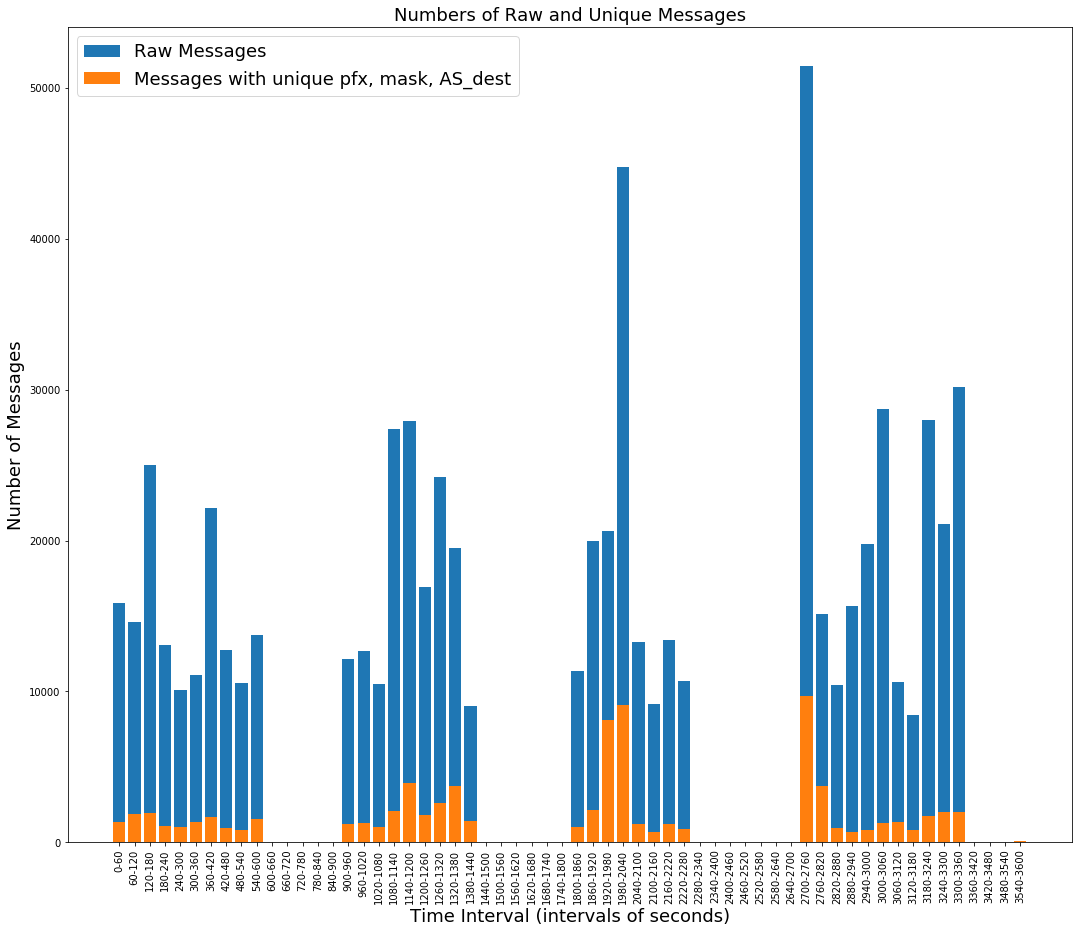

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 15)

intervals = ['{:d}-{:d}'.format(k * interval, (k + 1) * interval) for k in td.keys()]
regular_buckets = [len(b) for b in td.values()]
u_buckets = [len(b) for b in buckets_unique.values()]

r_bar = ax.bar(intervals, regular_buckets)
u_bar = ax.bar(intervals, u_buckets)

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(rotation=90)
plt.title('Numbers of Raw and Unique Messages', fontsize=18)
plt.ylabel('Number of Messages')
plt.xlabel('Time Interval (intervals of seconds)')
plt.legend((r_bar, u_bar), ('Raw Messages', 'Messages with unique pfx, mask, AS_dest'), fontsize=18)
plt.show()

Clearly, there is quite a variety of how many of these "unique" messages appear during each time period, and how they compare to the raw number of messages. Note the average proportion of "unique" messages to raw messages:

In [25]:
proportions = [len(b) / len(a) if len(b) > 0 else 0 for (a, b) in zip(td.values(), buckets_unique.values())]
statistics.mean(proportions)

0.08437295133766876

### Some Thoughts
The chart above reveals just how much duplication occurs in BGP, where under 10% of the total number of messages are distinct, when considering the basic composite key of (prefix, mask, and AS destination). Again, these numbers don't reflect the _actual number of messages captured_ in the dataset, since some messages aggregate many prefixes. Even so, the sheer amount of duplication is highly interesting.

Now, how much impact does this temporal difference really have on the different messages? How many of the "time buckets" does each "unique" message span? Using our previously calculated example, let's find out:

In [26]:
# Mark a 1 if the message appeared in an interval, 0 otherwise.
intervals_per_message = [[1 if m in b else 0 for b in buckets_unique.values()] for m in unique_messages]
# Sum the number of time intervals the message appeared in
appearances = [sum(t) for t in intervals_per_message]
print('Average number of time intervals for each message: {:f}'.format(statistics.mean(appearances)))
print('Standard deviation of number of time intervals for each message: {:f}'.format(statistics.stdev(appearances)))
print('Maximum number of appearances for any one message: {:d}'.format(max(appearances)))
print('Mode number of appearances for any one message: {:d}'.format(statistics.mode(appearances)))

Average number of time intervals for each message: 2.623839
Standard deviation of number of time intervals for each message: 3.743804
Maximum number of appearances for any one message: 39
Mode number of appearances for any one message: 1


On average, each unique message is found in about 2.6 buckets; perhaps a different time interval should be considered for this reason... However, the mode is 1 bucket per message, as might be expected, and the standard deviation of 3.74 suggests that this data is reasonably clustered around the mean, indicating that not many messages span a great amount of time, at least for this data set.